# Coal production in mines 2013

by: Scott Hibberd

Abstract: Analysis with interesting conclusions...

In [9]:
% matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

sns.set()

## Cleaned Data

We cleaned this data in the notebook stored in: deliver/Data_cleaning.ipynb

In [10]:
# Read in our data and promote the 3rd row to the header row and index on the MSHA ID column
df = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col='MSHA ID')
df[['Year', 'Mine_Name']].head()

,Year,Mine_Name
MSHA ID,,
103381,2013,Tacoa Highwall Miner
103404,2013,Reid School Mine
100759,2013,North River #1 Underground Min
103246,2013,Bear Creek
103451,2013,Knight Mine


# Predict the Production of Coal Mines

In [11]:
features = ['Average_Employees',
            'Labor_Hours',
           ]

categoricals = ['Mine_State',
                'Mine_County',
                'Mine_Status',
                'Mine_Type',
                'Company_Type',
                'Operation_Type',
                'Union_Code',
                'Coal_Supply_Region',  
                ]

target = 'log_production'

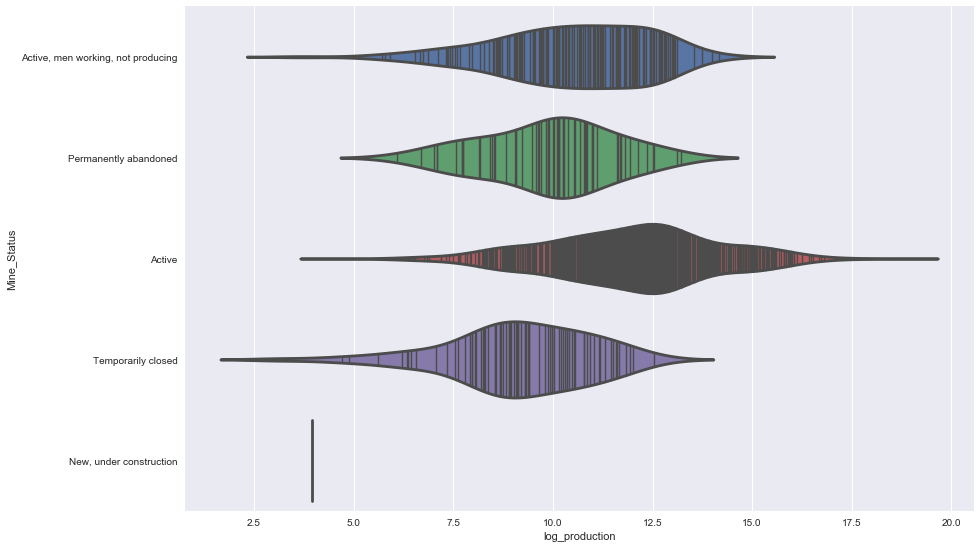

In [12]:
fig = plt.subplots(figsize=(14,8))
sns.set_context('poster')
sns.violinplot(y='Mine_Status', x='log_production', data=df,
               split=True, inner="stick")
plt.tight_layout()

plt.savefig("../figures/Coal_prediction_company_type_vs_log_production.png")

In [13]:
dummy_categoricals = []
for categorical in categoricals:
    # Avoid the dummy variable trap!
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    df = pd.concat([df, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

# Random Forest Regressor

In [14]:
train, test = train_test_split(df, test_size=0.3)

In [15]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

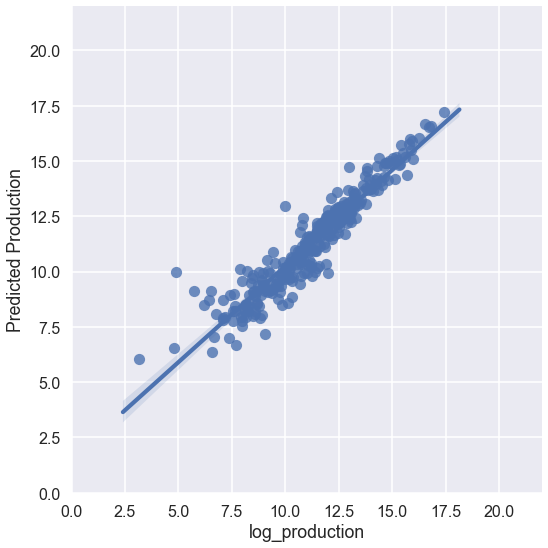

In [16]:
fig = plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]))
plt.ylabel("Predicted Production")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.tight_layout()
plt.savefig("../figures/Coal-production-RF-prediction.png")

In [17]:
predicted = rf.predict(test[features + dummy_categoricals])
print("R^2 score:", r2_score(test[target], predicted))
print("Explained variance:", explained_variance_score(test[target], predicted))
print("MSE:",mean_squared_error(test[target], predicted))

R^2 score: 0.891247781533
Explained variance: 0.892319790061
MSE: 0.615814293438


In [18]:
rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns,
                              'importance':rf.feature_importances_
                             }).sort_values(by='importance', ascending=False).reset_index(drop=True)

rf_importances.head(5)

,importance,name
0,0.830428,Labor_Hours
1,0.063162,Average_Employees
2,0.010795,Coal_Supply_Region_Powder River Basin
3,0.007306,Mine_Type_Surface
4,0.004838,Mine_State_West Virginia (Southern)


## Conclusion

Detailed conclusion